In [1]:
%load_ext autoreload
%autoreload 2

# TUNED | RANDOM FOREST | ENTROPY VARIABLES

In [2]:
import sys
sys.path.append('../../')
import tokamakTK


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support


pd.set_option('display.max_columns', None)
path = "../../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical and Numerical Data

In [4]:
features = ['ZEFFNEO', 'EPS', 'WFICFORM', 'BETASTAR', 
            'RHOSTAR', 'DWDIA', 'KAREA', 'NEL', 'OMEGACYCL', 'ENBI', 'NUSTAR']

"""
RESULTS CHANGE DRAMATICALLY BY THE PRESENCE OF NUSTAR
"""



DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

In [5]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [6]:
# Define random forest classifier with preprocessor as a pipeline

rf = RandomForestClassifier(min_samples_split=2,
                            min_samples_leaf=1,
                            n_estimators = 95,
                            max_depth = 20,
                            criterion='entropy',
                            max_features=None,
                            random_state=71
                           )

rf.fit(X_train, y_train)
y_pred= rf.predict_proba(X_test)

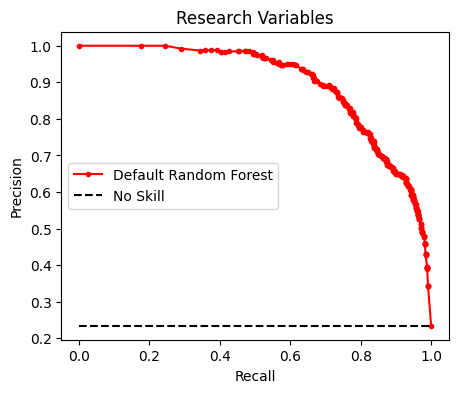

In [7]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Research Variables")
plt.legend();

In [8]:
y_pred_ = rf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.83709273, 0.9282329 ]),
 array([0.75909091, 0.95473538]),
 array([0.79618594, 0.94129763]),
 array([ 440, 1436]))

## [Feature Importance Based on Mean Decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**WARNING**:  Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance.

In [9]:
importances = rf.feature_importances_

feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

print(feature_importances)

      feature  importance
0      NUSTAR    0.250165
1     RHOSTAR    0.217902
2        ENBI    0.104378
3   OMEGACYCL    0.089535
4    BETASTAR    0.082908
5         NEL    0.080946
6         EPS    0.065075
7       KAREA    0.061181
8       DWDIA    0.017522
9     ZEFFNEO    0.015915
10   WFICFORM    0.014471


In [10]:
df = pd.DataFrame(feature_importances)
df.feature.unique()

array(['NUSTAR', 'RHOSTAR', 'ENBI', 'OMEGACYCL', 'BETASTAR', 'NEL', 'EPS',
       'KAREA', 'DWDIA', 'ZEFFNEO', 'WFICFORM'], dtype=object)

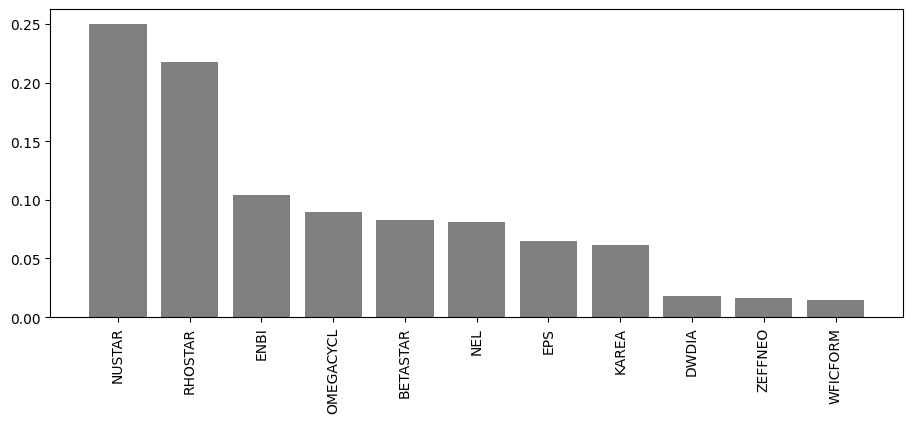

In [11]:
plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

In [12]:
# Quite Important
df[df.importance > 1e-3]

,feature,importance
0,NUSTAR,0.250165
1,RHOSTAR,0.217902
2,ENBI,0.104378
3,OMEGACYCL,0.089535
4,BETASTAR,0.082908
5,NEL,0.080946
6,EPS,0.065075
7,KAREA,0.061181
8,DWDIA,0.017522
9,ZEFFNEO,0.015915


In [13]:
# Not so important
df[df.importance < 1e-3]

,feature,importance


In [14]:
df[df.importance == 0]

,feature,importance
